## IMPORT LIBRARIES

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from numba import jit
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
import seaborn as sb
import pandas as pd
import time

## Function: im2index(im)

In [2]:
@jit(nopython=True)
def im2index(im):
    assert len(im.shape) == 3
    r = im[:, :, 0].ravel()
    g = im[:, :, 1].ravel()
    b = im[:, :, 2].ravel()
    label = np.zeros((r.shape[0], 1), dtype=np.uint8)
    for i in range(r.shape[0]):
        # Unknown
        if r[i] == 0 and g[i] == 0 and b[i] == 0:
            label[i] = 0
        # Forest
        elif r[i] == 0 and g[i] == 255 and b[i] == 255:
            label[i] = 1
        # Built-up
        elif r[i] == 255 and g[i] == 0 and b[i] == 0:
            label[i] = 2
        # Water
        elif r[i] == 0 and g[i] == 0 and b[i] == 255:
            label[i] = 3
        # Farmland
        elif r[i] == 0 and g[i] == 255 and b[i] == 0:
            label[i] = 4
        # Meadow
        elif r[i] == 255 and g[i] == 255 and b[i] == 0:
            label[i] = 5
        else:
            label[i] = 0
    indx_img = np.reshape(label, (-1, im.shape[1]))
    return indx_img

## Functions: 
    confusion_metrics(target, predict, num_of_classes)
    norm_confusion_metrics(conf_matrix)
    get_confusion_metrics_score(class_index, conf_metric)
    precision(tp, fp)
    recall(tp, fn)
    accuracy(tp, tn, fp, fn)
    iou_conf(tp, fn, fp)
    percentage(num_of_classes, target)

In [3]:
import numpy as np

def confusion_metrics(target, predict, num_of_classes):
    conf_metrics = np.zeros((num_of_classes, num_of_classes), dtype=np.int)
    for h in range(target.shape[0]):
        for w in range(target.shape[1]):
            conf_metrics[target[h,w], predict[h,w]] += 1
    return conf_metrics


def norm_confusion_metrics(conf_matrix):

    '''
    Return a normalize confusion metric.
    Divide each cell of a row by the sum of each row
    '''

    new_cf = np.zeros(conf_matrix.shape, dtype=np.float)
    for i in range(conf_matrix.shape[0]):
        new_cf[i,:] = conf_matrix[i,:] / sum(conf_matrix[i,:])

    for k in range(6):
        for l in range(6):
            if new_cf[k,l] >= 0:
                new_cf[k,l] = new_cf[k,l]
            else:
                new_cf[k,l] = 0

    return new_cf


def get_confusion_metrics_score(class_index, conf_metric):
    '''
        Return an array of tp, fp, fn, tn respectively
    '''
    conf_copy = conf_metric.copy()
    conf_copy[class_index, :] = 0
    conf_copy[:, class_index] = 0

    tp = conf_metric[class_index, class_index]
    fp = sum(conf_metric[:, class_index]) - tp
    fn = sum(conf_metric[class_index, :]) - tp
    tn = sum(sum(conf_copy))
    
    return [tp, fp, fn, tn]


def precision(tp, fp):
    if tp == 0:
        return 1
    elif tp + fp == 0:
        return 1
    else:
        return tp / (tp + fp)

    
def recall(tp, fn):
    if tp == 0:
        return 1
    elif tp + fn == 0:
        return 1
    else:
        return tp / (tp + fn)

    
def accuracy(tp, tn, fp, fn):
    if tp + tn + fp + fn == 0:
        return 1
    else:
        return (tp + tn) / (tp + tn + fp + fn)


def iou_conf(tp, fn, fp):
    if tp + fn + fp == 0:
        return 1
    return tp / (tp + fn + fp)


def iou(target, predict):
    intersection = np.logical_and(target, predict)
    union = np.logical_or(target, predict)
    iou_score = np.sum(intersection) / np.sum(union)
    if iou_score is None:
        print("null")
        return 0
    else:
        return iou_score

def percentage(num_of_classes, target):
    total = target.shape[0] * target.shape[1]
    percentage = np.arange(0, num_of_classes, dtype=np.int)
    
    for i in target.ravel():
        percentage[i] += 1

    return (percentage/total) * 100

## Read Image and ...

In [4]:
img = '2016-08-07_0001746797.png'
original = Image.open(os.path.join('Original', img))
target = Image.open(os.path.join('Target', img))
predict = Image.open(os.path.join('Prediction', img))

In [5]:
original = np.asarray(original)
target = np.asarray(target)
predict = np.asarray(predict)

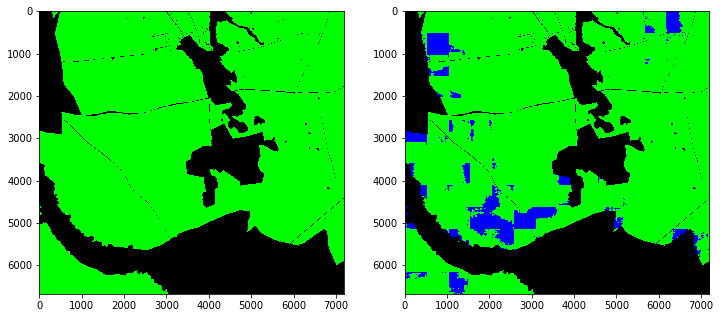

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(target)
plt.subplot(122)
plt.imshow(predict)
plt.show()

In [7]:
start_ms = int(round(time.time() * 1000))

tar_ind = im2index(target)
pre_ind = im2index(predict)

end_ms = int(round(time.time() * 1000))
print(f'Time: {(end_ms - start_ms)/60}')

Time: 16.916666666666668


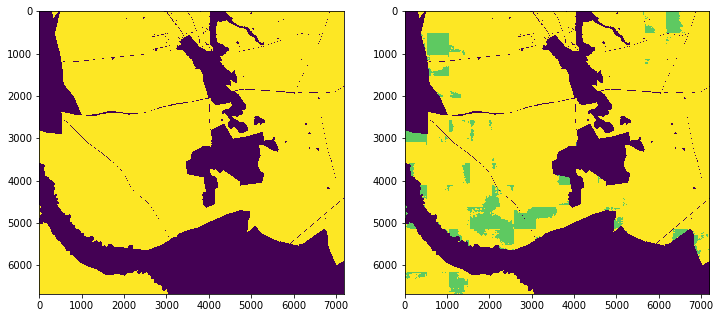

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(tar_ind)
plt.subplot(122)
plt.imshow(pre_ind)
plt.show()

In [9]:
cf = confusion_metrics(target=tar_ind, predict=pre_ind, num_of_classes=6)
print(cf)

[[13783449        0        0       80     4377        0]
 [       0        0        0        0        0        0]
 [       0        0        0        0        0        0]
 [       0        0        0        0        0        0]
 [   30126     5907       17  2527092 31545710        0]
 [       0        0        0        0        0        0]]


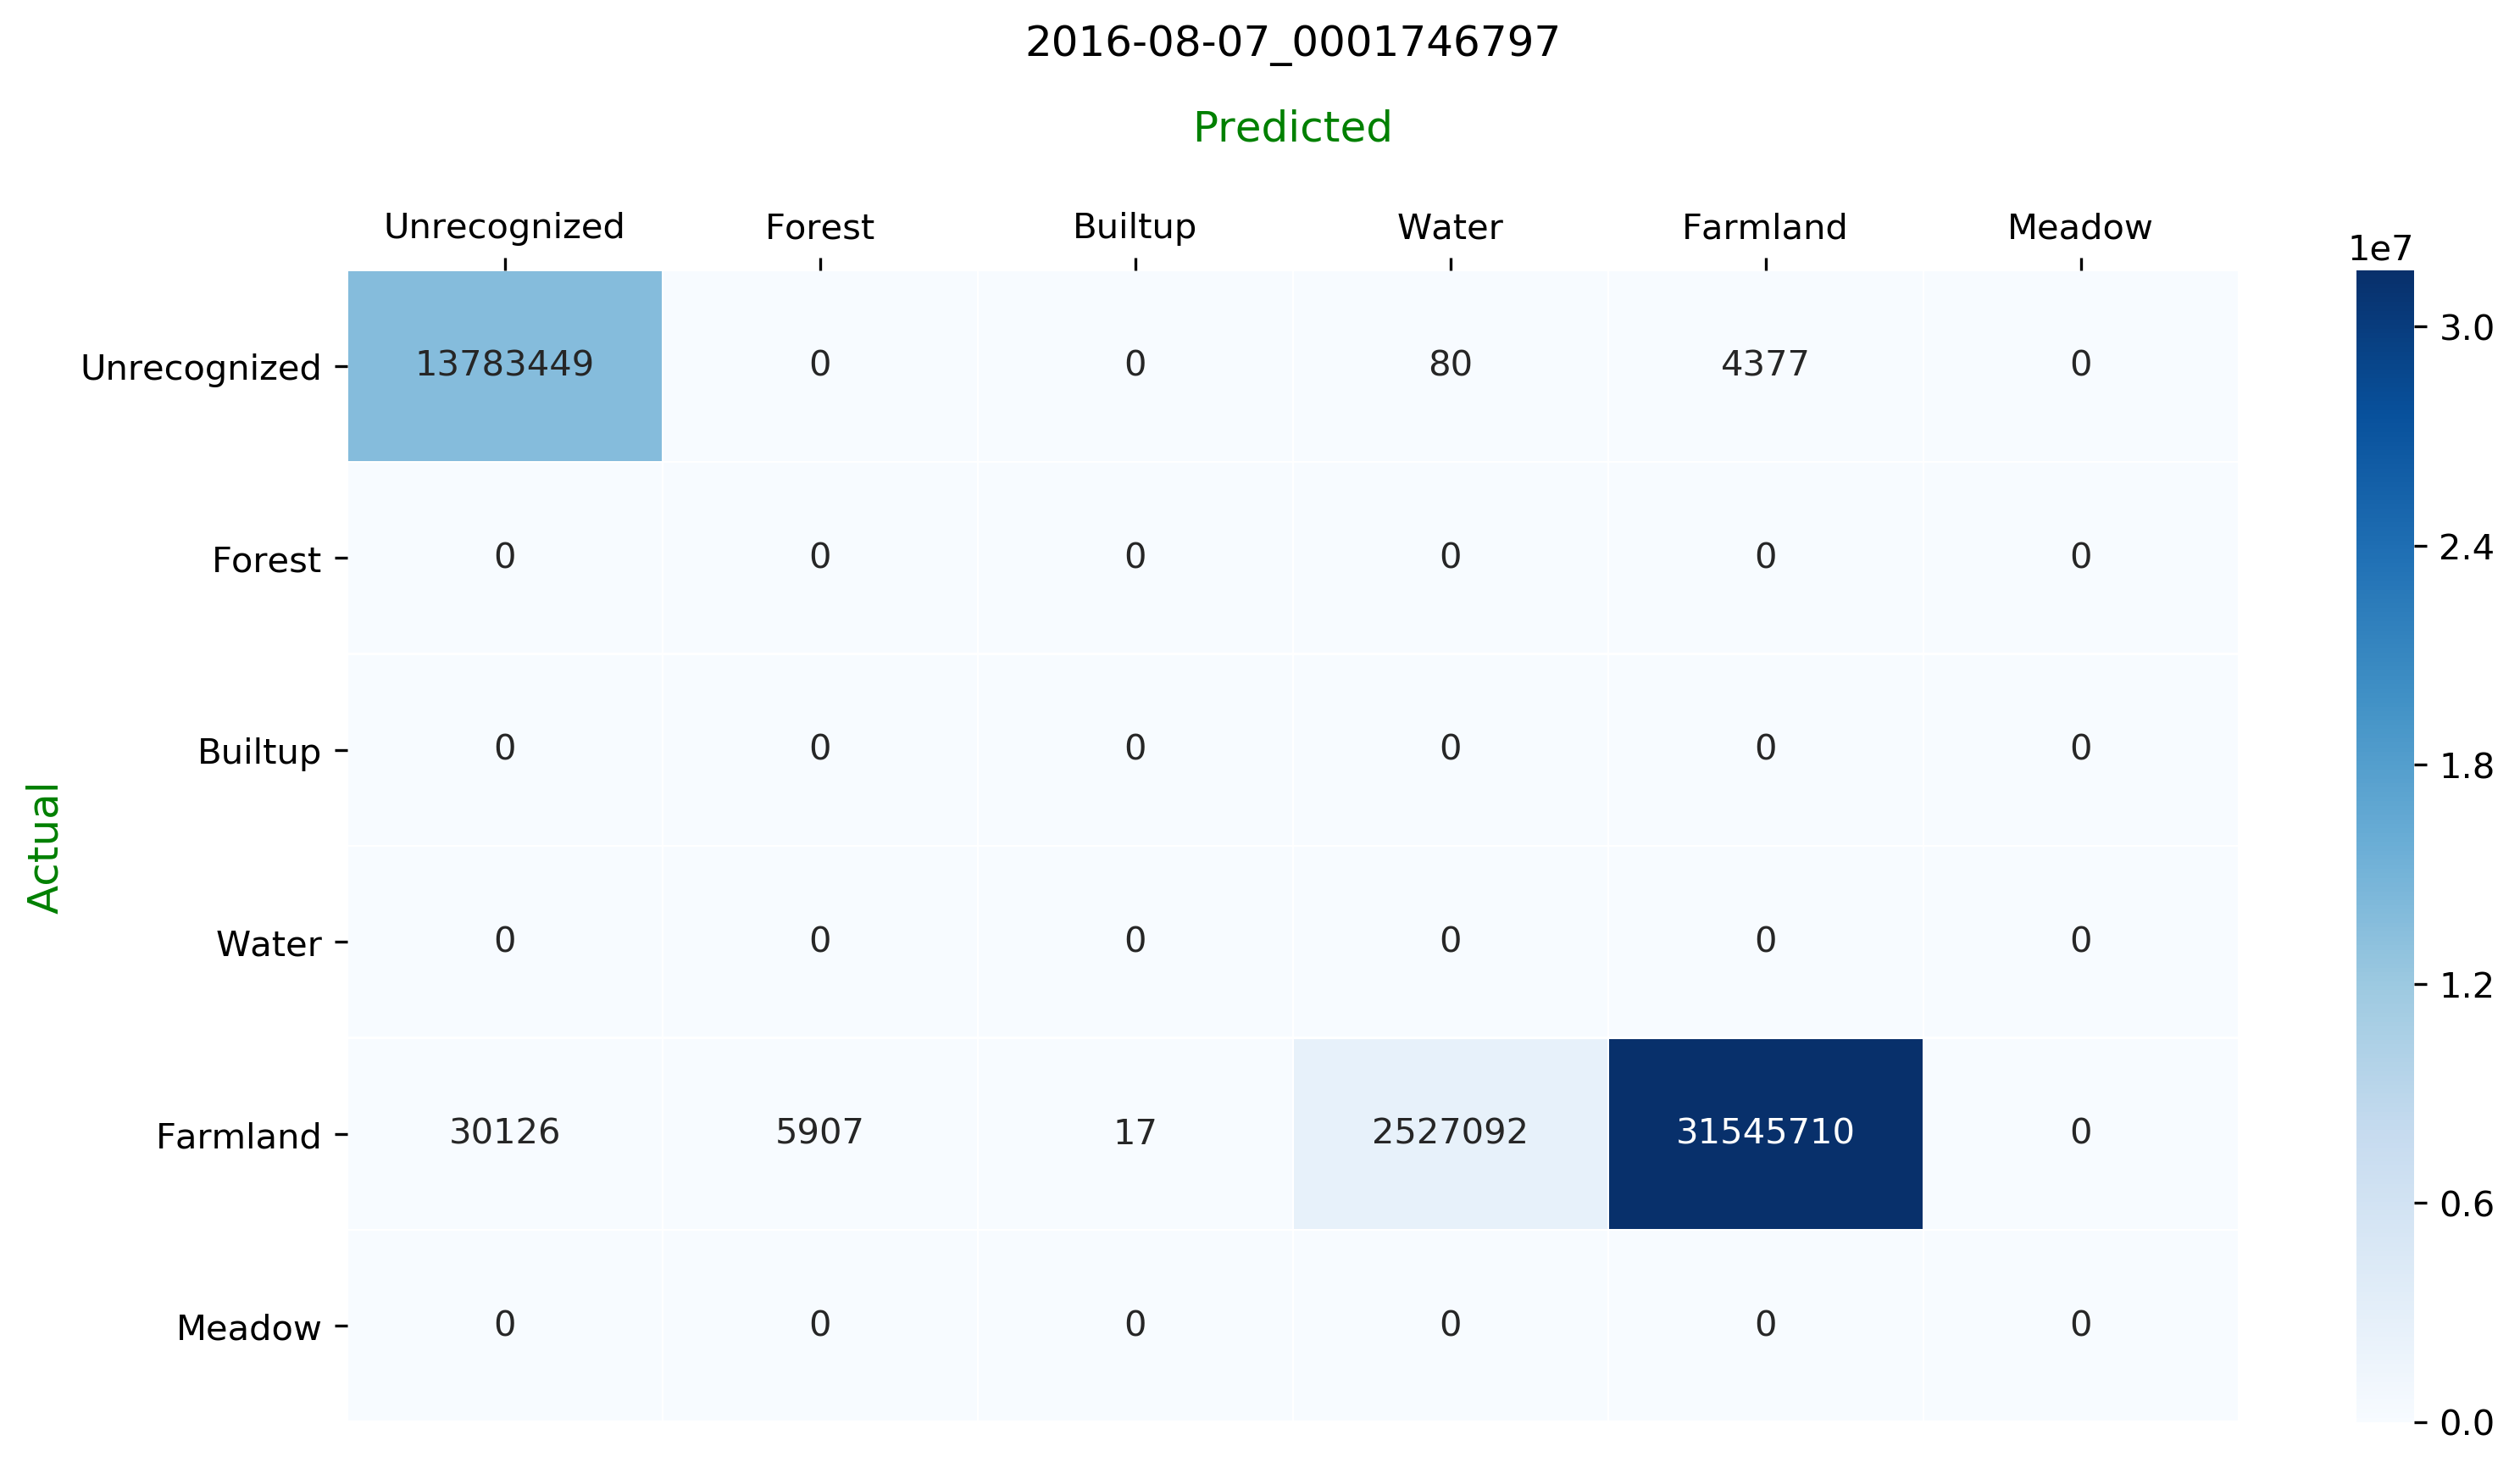

In [10]:
df_cm = pd.DataFrame(cf, index = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]], 
                     columns = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]])
plt.figure(num=None, figsize=(12,6), dpi=300)
ax = sb.heatmap(df_cm, annot=True, linewidths=.3, cmap='Blues', fmt='d')
plt.yticks(rotation=0)
plt.xlabel('Predicted', size=12, color='g', labelpad=20)
plt.ylabel('Actual', size=12, color='g')
plt.title(img.rstrip('.png'), pad=15)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
# plt.savefig(img)

In [11]:
norm_conf = norm_confusion_metrics(cf)
print(norm_conf)

[[9.99676746e-01 0.00000000e+00 0.00000000e+00 5.80218635e-06
  3.17452121e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.83231133e-04 1.73180851e-04 4.98404344e-07 7.40890371e-02
  9.24854053e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


/home/iansarker/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


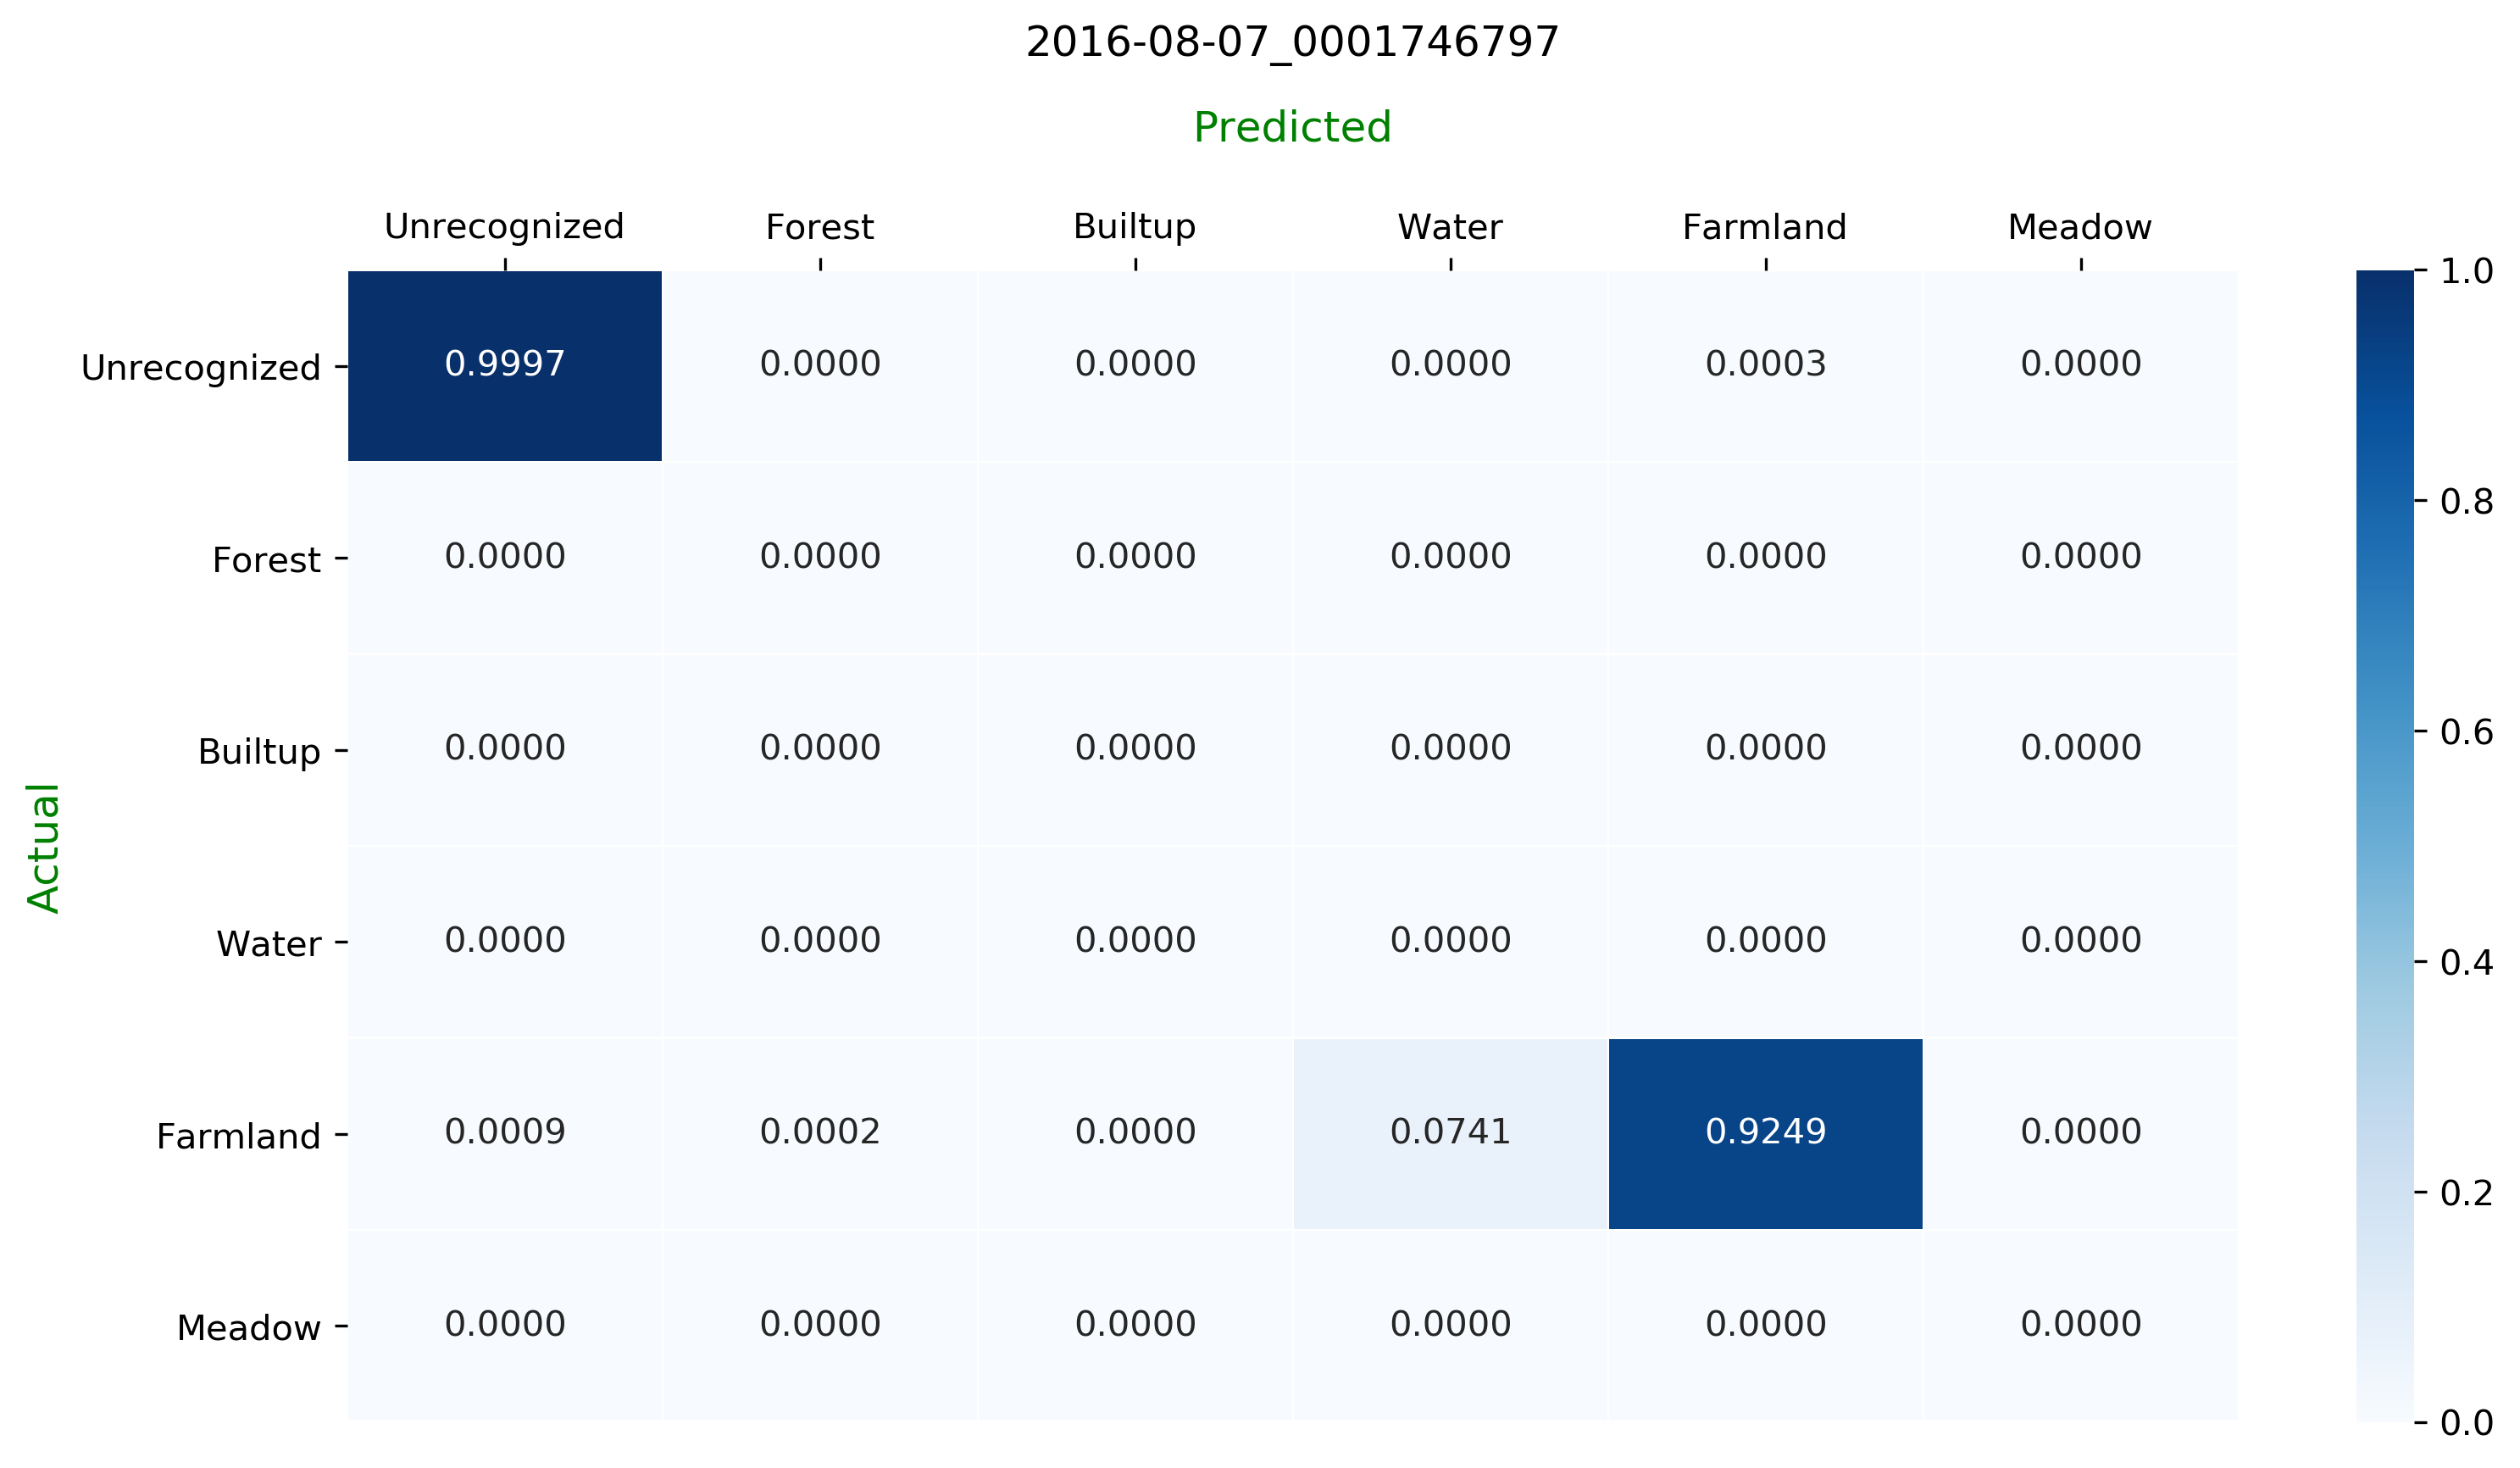

In [22]:
df_cm = pd.DataFrame(norm_conf, index = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]], 
                     columns = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]])
plt.figure(num=None, figsize=(12,6), dpi=300)
ax = sb.heatmap(df_cm, annot=True, linewidths=.3, cmap='Blues', fmt='.4f')
plt.yticks(rotation=0)
plt.xlabel('Predicted', size=12, color='g', labelpad=20)
plt.ylabel('Actual', size=12, color='g')
plt.title(img.rstrip('.png'), pad=15)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
# plt.savefig(img)

### Save the Confusion Matrix into CSV

In [11]:
df_cm.reset_index(level=0, inplace=True)

In [12]:
add_to_first_col = []
percent = percentage(num_of_classes=6, target=tar_ind)
[add_to_first_col.append(round(p,2)) for p in percent]
print(add_to_first_col)

[28.79, 0.0, 0.0, 0.0, 71.21, 0.0]


In [13]:
data_frame_np = df_cm.to_numpy()
data_frame_np_ = np.zeros((7,7), dtype=np.object)
data_frame_np_[0,:] = df_cm.columns.values
data_frame_np_[1:] = data_frame_np
df_cm[0:]
# df_cm.to_csv(img.rstrip('.png') + '.csv', index=True)

,index,Unrecognized,Forest,Builtup,Water,Farmland,Meadow
0,Unrecognized,13783449,0,0,80,4377,0
1,Forest,0,0,0,0,0,0
2,Builtup,0,0,0,0,0,0
3,Water,0,0,0,0,0,0
4,Farmland,30126,5907,17,2527092,31545710,0
5,Meadow,0,0,0,0,0,0


In [14]:
csv_header = []

# Image title header
csv_header.append('Title')

# Area header
for i in range(data_frame_np_.shape[0]):
    if data_frame_np_[0,i] == 'index':
        pass
    else:
        csv_header.append('Area-' + data_frame_np_[0,i])

# Confusion matrix header
for i in range(data_frame_np_.shape[0]):
    for j in range(data_frame_np_.shape[1]):
        if data_frame_np_[0,j] == 'index' or data_frame_np_[i, 0] == 'index':
            pass
        else:
            str_class = data_frame_np_[i, 0] + '-' + data_frame_np_[j, 0]
            csv_header.append(str_class)

In [15]:
csv_header

['Title',
 'Area-Unrecognized',
 'Area-Forest',
 'Area-Builtup',
 'Area-Water',
 'Area-Farmland',
 'Area-Meadow',
 'Unrecognized-Unrecognized',
 'Unrecognized-Forest',
 'Unrecognized-Builtup',
 'Unrecognized-Water',
 'Unrecognized-Farmland',
 'Unrecognized-Meadow',
 'Forest-Unrecognized',
 'Forest-Forest',
 'Forest-Builtup',
 'Forest-Water',
 'Forest-Farmland',
 'Forest-Meadow',
 'Builtup-Unrecognized',
 'Builtup-Forest',
 'Builtup-Builtup',
 'Builtup-Water',
 'Builtup-Farmland',
 'Builtup-Meadow',
 'Water-Unrecognized',
 'Water-Forest',
 'Water-Builtup',
 'Water-Water',
 'Water-Farmland',
 'Water-Meadow',
 'Farmland-Unrecognized',
 'Farmland-Forest',
 'Farmland-Builtup',
 'Farmland-Water',
 'Farmland-Farmland',
 'Farmland-Meadow',
 'Meadow-Unrecognized',
 'Meadow-Forest',
 'Meadow-Builtup',
 'Meadow-Water',
 'Meadow-Farmland',
 'Meadow-Meadow']

In [16]:
csv_rows = []

# Title rows
csv_rows.append(img.rstrip('.png'))

# Area rows
[csv_rows.append(round(i,2)) for i in percent]

# Confusion matrix rows
for i in range(1, data_frame_np_.shape[0]):
    for j in range(1, data_frame_np_.shape[1]):
        csv_rows.append(data_frame_np_[i, j])

In [17]:
len(csv_rows)

43

In [18]:
data_frame_csv = pd.DataFrame(columns=csv_header)
with open('my_csv.csv', 'a') as f:
    data_frame_csv.loc[0] = np.array(csv_rows).reshape(-1,len(csv_rows))[0]
    data_frame_csv.to_csv(f, header=True)
data_frame_csv
# np.array(csv_rows).reshape(-1,len(csv_rows))[0]

,Title,Area-Unrecognized,Area-Forest,Area-Builtup,Area-Water,Area-Farmland,Area-Meadow,Unrecognized-Unrecognized,Unrecognized-Forest,Unrecognized-Builtup,...,Farmland-Builtup,Farmland-Water,Farmland-Farmland,Farmland-Meadow,Meadow-Unrecognized,Meadow-Forest,Meadow-Builtup,Meadow-Water,Meadow-Farmland,Meadow-Meadow
0,2016-08-07_0001746797,28.79,0.0,0.0,0.0,71.21,0.0,13783449,0,0,...,17,2527092,31545710,0,0,0,0,0,0,0


In [125]:
percent = percentage(num_of_classes=6, target=tar_ind)

for i in range(6):
    tp, fp, fn, tn = get_confusion_metrics_score(class_index=i, conf_metric=cf)
    
    acc = accuracy(tp=tp, tn=tn, fp=fp, fn=fn)
    iou_sc = iou_conf(tp=tp, fp=fp, fn=fn)
    prec = precision(tp=tp, fp=fp)
    rec = recall(tp=tp, fn=fn)
    
    print(f'Index: {i}')
    print(f'\tPercentage: {round(percent[i],2)}%')
    print(f'\tAccuracy: {acc}')
    print(f'\tIoU: {iou_sc}')
    print(f'\tPrecision: {prec}')
    print(f'\tRecall: {rec}')

Index: 0
	Percentage: 28.79%
	Accuracy: 0.9992779678323949
	IoU: 0.9974972557597204
	Precision: 0.9978191018617556
	Recall: 0.9996767456929283
Index: 1
	Percentage: 0.0%
	Accuracy: 0.9998766722373986
	IoU: 0.0
	Precision: 1
	Recall: 1
Index: 2
	Percentage: 0.0%
	Accuracy: 0.9999996450699231
	IoU: 0.0
	Precision: 1
	Recall: 1
Index: 3
	Percentage: 0.0%
	Accuracy: 0.9472370969241801
	IoU: 0.0
	Precision: 1
	Recall: 1
Index: 4
	Percentage: 71.21%
	Accuracy: 0.9463947225822674
	IoU: 0.9247353863804567
	Precision: 0.9998612682113999
	Recall: 0.9248540525491741
Index: 5
	Percentage: 0.0%
	Accuracy: 1.0
	IoU: 1
	Precision: 1
	Recall: 1


## Plotting

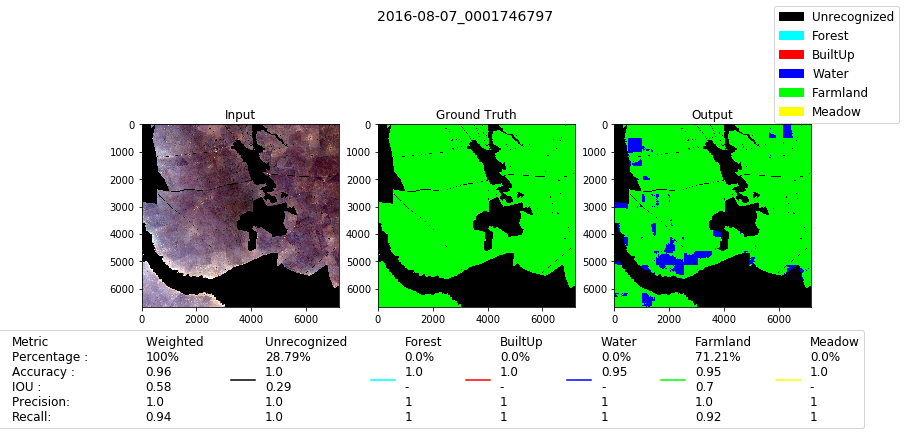

In [21]:
num_of_classes = 6
ac = []
io = []
pr = []
rc = []
pe = []

percent = percentage(num_of_classes=num_of_classes, target=tar_ind)
for i in range(num_of_classes):
    tp, fp, fn, tn = get_confusion_metrics_score(class_index=i, conf_metric=cf)
    acc = accuracy(tp=tp, tn=tn, fp=fp, fn=fn)
    iou_sc = iou_conf(tp=tp, fn=tn, fp=fp)
    prec = precision(tp=tp, fp=fp)
    rec = recall(tp=tp, fn=fn)

    ac.append(round(acc, 2))
    io.append(round(iou_sc, 2))
    pr.append(round(prec, 2))
    rc.append(round(rec, 2))
    pe.append(round(percent[i], 2))

#     print(f'Index: {i}\tPercentage: {percent[i]}\tAccuracy: {acc}\tIOU: {iou_sc}\tPrecision: {prec}\tRecall: {rec}')

# Plot the accuracy, iou, precision and recall into plot for each classes
f, axarr = plt.subplots(1, 3, figsize=(12, 6))
f.suptitle(img.rstrip('.png'), fontsize=14)

axarr[0].imshow(original)
axarr[0].title.set_text('Input')

axarr[1].imshow(target)
axarr[1].title.set_text('Ground Truth')

axarr[2].imshow(predict)
axarr[2].title.set_text('Output')

# Calculate weighted accuracy
weight_acc = (pe[0]*ac[0] + pe[1]*ac[1] + pe[2]*ac[2] + pe[3]*ac[3] + pe[4]*ac[4] + pe[5]*ac[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
weight_iou = (pe[0]*io[0] + pe[1]*io[1] + pe[2]*io[2] + pe[3]*io[3] + pe[4]*io[4] + pe[5]*io[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
weight_rec = (pe[0]*pr[0] + pe[1]*pr[1] + pe[2]*pr[2] + pe[3]*pr[3] + pe[4]*pr[4] + pe[5]*pr[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
weight_pre = (pe[0]*rc[0] + pe[1]*rc[1] + pe[2]*rc[2] + pe[3]*rc[3] + pe[4]*rc[4] + pe[5]*rc[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )

weight_acc = round(weight_acc,2)
weight_iou = round(weight_iou,2)
weight_rec = round(weight_rec,2)
weight_pre = round(weight_pre,2)

unrecognized = mpatches.Patch(color="#000000", label="Unrecognized")
forest = mpatches.Patch(color='#00FFFF', label='Forest')
builtUp = mpatches.Patch(color='#FF0000', label='BuiltUp')
water = mpatches.Patch(color='#0000FF', label='Water')
farmland = mpatches.Patch(color='#00FF00', label='Farmland')
meadow = mpatches.Patch(color='#FFFF00', label='Meadow')

f.legend(loc='upper right', fontsize='12', handles=[unrecognized, forest, builtUp, water, farmland, meadow])
for i in range (len(ac)):
    if io[i] == 0:
        io[i] = '-'
    if pr[i] == 0:
        pr[i] = '-'
    if rc[i] == 0:
        rc[i] = '-'

axarr[0].plot([], [], color='#FFFFFF', label="Metric\nPercentage :\nAccuracy :\nIOU :\nPrecision: \nRecall:")
axarr[0].plot([], [], color='#FFFFFF', label="Weighted \n100%\n"+str(weight_acc)+"\n"+str(weight_iou)+"\n"+str(weight_rec)+"\n"+str(weight_pre))
axarr[0].plot([], [], color='#000000', label="Unrecognized\n"+str(pe[0])+"%\n"+str(ac[0])+"\n"+str(io[0])+"\n"+str(pr[0])+"\n"+str(rc[0]))
axarr[0].plot([], [], color='#00FFFF', label="Forest\n"+str(pe[1])+"%\n"+str(ac[1])+"\n"+str(io[1])+"\n"+str(pr[1])+"\n"+str(rc[1]))
axarr[0].plot([], [], color='#FF0000', label="BuiltUp\n"+str(pe[2])+"%\n"+str(ac[2])+"\n"+str(io[2])+"\n"+str(pr[2])+"\n"+str(rc[2]))
axarr[0].plot([], [], color='#0000FF', label="Water\n"+str(pe[3])+"%\n"+str(ac[3])+"\n"+str(io[3])+"\n"+str(pr[3])+"\n"+str(rc[3]))
axarr[0].plot([], [], color='#00FF00', label="Farmland\n"+str(pe[4])+"%\n"+str(ac[4])+"\n"+str(io[4])+"\n"+str(pr[4])+"\n"+str(rc[4]))
axarr[0].plot([], [], color='#FFFF00', label="Meadow\n"+str(pe[5])+"%\n"+str(ac[5])+"\n"+str(io[5])+"\n"+str(pr[5])+"\n"+str(rc[5]))

f.legend(loc='lower center', bbox_to_anchor=(0.485, 0.00), shadow=False, ncol=10, fontsize='12')
# plt.savefig(os.path.join(figure_dir, img), dpi=150)
plt.show()

## MAIN FUNCTION

In [144]:
'''
    Main Function
'''

org_dir ='Original'
tar_dir ='Target'
pred_dir ='Prediction'

figure_dir = 'result/figure'
conf_mat_dir = 'result/confusion-matrix'

num_of_classes = 6

for img in os.listdir('Original'):
    print(f'Current image: {img.rstrip(".png")}')

    original = Image.open(os.path.join(org_dir, img))
    target = Image.open(os.path.join(tar_dir, img))
    predict = Image.open(os.path.join(pred_dir, img))

    original = np.asarray(original)
    target = np.asarray(target)
    predict = np.asarray(predict)

    tar_ind = im2index(target)
    pre_ind = im2index(predict)

    cf = confusion_metrics(target=tar_ind, predict=pre_ind, num_of_classes=num_of_classes)
    total = sum(sum(cf))
    norm_cf = cf/total
    
    ac = []
    io = []
    pr = []
    rc = []
    pe = []
#     percentage = np.arange(0,6, dtype=np.int)
#     for i in tar_ind.ravel():
#         percentage[i] += 1
    percentage = percentage(num_of_classes=num_of_classes, target=tar_ind)
    for i in range(num_of_classes):
        tp, fp, fn, tn = get_confusion_metrics_score(class_index=i, conf_metric=cf)
        acc = accuracy(tp=tp, tn=tn, fp=fp, fn=fn)
        iou_sc = iou_conf(tp=tp, fn=tn, fp=fp)
        prec = precision(tp=tp, fp=fp)
        rec = recall(tp=tp, fn=fn)
        
        ac.append(round(acc, 2))
        io.append(round(iou_sc, 2))
        pr.append(round(prec, 2))
        rc.append(round(rec, 2))
        pe.append(round(percentage[i], 2))
        
        print(f'Index: {i}\tPercentage: {percentage[i]}\tAccuracy: {acc}\tIOU: {iou_sc}\tPrecision: {prec}\tRecall: {rec}')
    
    # Plot and Save the confusion matrix table
    df_cm = pd.DataFrame(norm_cf, index = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]], 
                         columns = [i for i in ["Unrecognized", "Forest", "Builtup", "Water", "Farmland", "Meadow"]])
    plt.figure(num=None, figsize=(12,6), dpi=150)
    ax = sb.heatmap(df_cm, annot=True, linewidths=.2, cmap='Blues', fmt='.4f')
    plt.yticks(rotation=0)
    plt.title(img.rstrip('.png'))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.savefig(os.path.join(conf_mat_dir, img))
    
          
    # Plot the accuracy, iou, precision and recall into plot for each classes
    f, axarr = plt.subplots(1, 3, figsize=(12, 6))
    f.suptitle(img.rstrip('.png'), fontsize=14)

    axarr[0].imshow(original)
    axarr[0].title.set_text('Input')

    axarr[1].imshow(target)
    axarr[1].title.set_text('Ground Truth')

    axarr[2].imshow(predict)
    axarr[2].title.set_text('Output')

    # Calculate weighted accuracy
    weight_acc = (pe[0]*ac[0] + pe[1]*ac[1] + pe[2]*ac[2] + pe[3]*ac[3] + pe[4]*ac[4] + pe[5]*ac[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
    weight_iou = (pe[0]*io[0] + pe[1]*io[1] + pe[2]*io[2] + pe[3]*io[3] + pe[4]*io[4] + pe[5]*io[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
    weight_rec = (pe[0]*pr[0] + pe[1]*pr[1] + pe[2]*pr[2] + pe[3]*pr[3] + pe[4]*pr[4] + pe[5]*pr[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )
    weight_pre = (pe[0]*rc[0] + pe[1]*rc[1] + pe[2]*rc[2] + pe[3]*rc[3] + pe[4]*rc[4] + pe[5]*rc[5]) / (pe[0] + pe[1] + pe[2] + pe[3] + pe[4] +pe[5] )

    weight_acc = round(weight_acc,2)
    weight_iou = round(weight_iou,2)
    weight_rec = round(weight_rec,2)
    weight_pre = round(weight_pre,2)

    unrecognized = mpatches.Patch(color="#000000", label="Unrecognized")
    forest = mpatches.Patch(color='#00FFFF', label='Forest')
    builtUp = mpatches.Patch(color='#FF0000', label='BuiltUp')
    water = mpatches.Patch(color='#0000FF', label='Water')
    farmland = mpatches.Patch(color='#00FF00', label='Farmland')
    meadow = mpatches.Patch(color='#FFFF00', label='Meadow')
    
    f.legend(loc='upper right', fontsize='12', handles=[unrecognized, forest, builtUp, water, farmland, meadow])
    for i in range (len(ac)):
        if io[i] == 0:
            io[i] = '-'
        if pr[i] == 0:
            pr[i] = '-'
        if rc[i] == 0:
            rc[i] = '-'

    axarr[0].plot([], [], color='#FFFFFF', label="Metric\nPercentage :\nAccuracy :\nIOU :\nPrecision: \nRecall:")
    axarr[0].plot([], [], color='#FFFFFF', label="Weighted \n100%\n"+str(weight_acc)+"\n"+str(weight_iou)+"\n"+str(weight_rec)+"\n"+str(weight_pre))
    axarr[0].plot([], [], color='#000000', label="Unrecognized\n"+str(pe[0])+"%\n"+str(ac[0])+"\n"+str(io[0])+"\n"+str(pr[0])+"\n"+str(rc[0]))
    axarr[0].plot([], [], color='#00FFFF', label="Forest\n"+str(pe[1])+"%\n"+str(ac[1])+"\n"+str(io[1])+"\n"+str(pr[1])+"\n"+str(rc[1]))
    axarr[0].plot([], [], color='#FF0000', label="BuiltUp\n"+str(pe[2])+"%\n"+str(ac[2])+"\n"+str(io[2])+"\n"+str(pr[2])+"\n"+str(rc[2]))
    axarr[0].plot([], [], color='#0000FF', label="Water\n"+str(pe[3])+"%\n"+str(ac[3])+"\n"+str(io[3])+"\n"+str(pr[3])+"\n"+str(rc[3]))
    axarr[0].plot([], [], color='#00FF00', label="Farmland\n"+str(pe[4])+"%\n"+str(ac[4])+"\n"+str(io[4])+"\n"+str(pr[4])+"\n"+str(rc[4]))
    axarr[0].plot([], [], color='#FFFF00', label="Meadow\n"+str(pe[5])+"%\n"+str(ac[5])+"\n"+str(io[5])+"\n"+str(pr[5])+"\n"+str(rc[5]))
    
    f.legend(loc='lower center', bbox_to_anchor=(0.485, 0.00), shadow=False, ncol=10, fontsize='12')
    plt.savefig(os.path.join(figure_dir, img), dpi=150)
#     plt.show()

Current image: 2016-08-27_0001792971


KeyboardInterrupt: 